In [1]:
from torchvision import models
from PIL import Image

import torchvision
import os
import subprocess
import matplotlib.pyplot as plt
import torch
import requests
import time

plt.style.use('ggplot')

In [2]:
# Load the FCN ResNet101 segmentation model.
fcn = models.segmentation.fcn_resnet101(
    weights=torchvision.models.segmentation.FCN_ResNet101_Weights.DEFAULT
).eval()

Downloading: "https://download.pytorch.org/models/fcn_resnet101_coco-7ecb50ca.pth" to C:\Users\rdinh/.cache\torch\hub\checkpoints\fcn_resnet101_coco-7ecb50ca.pth
100%|██████████| 208M/208M [00:42<00:00, 5.09MB/s] 


In [3]:
# Helper function to download image and other files.
# Helper function to download file.
def download_file(url, save_name):
    if not os.path.exists(save_name):
        subprocess.run(['wget', url, '-O', save_name, '-q'])

In [4]:
# Create directory to store inference data
inference_dir = 'inference_data'
os.makedirs(inference_dir, exist_ok=True)

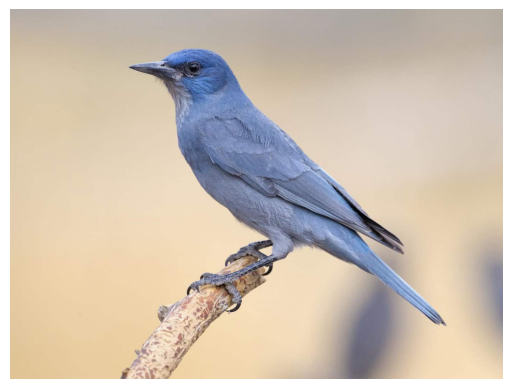

In [5]:
download_file(
    'https://learnopencv.com/wp-content/uploads/2022/10/bird.jpg',
    save_name=os.path.join(inference_dir, 'bird.jpg')
)
img = Image.open(os.path.join(inference_dir, 'bird.jpg'))
plt.imshow(img)
plt.axis('off')
plt.show()

In [6]:
# Apply the transformations needed
import torchvision.transforms as T
trf = T.Compose([T.Resize(256),
                 T.CenterCrop(224),
                 T.ToTensor(),
                 T.Normalize(mean = [0.485, 0.456, 0.406],
                             std = [0.229, 0.224, 0.225])])
inp = trf(img).unsqueeze(0)

Now that the image is preprocessed, we pass it through the model and get the out key, since the output of the model is a dictionary.

In [7]:
# Pass the input through the net
out = fcn(inp)['out']
print (out.shape)

torch.Size([1, 21, 224, 224])


Now we want to make the 21 channeled output into a 2D image where each pixel corresponds to a class.
The 2D image ([HxW]) will have each pixel correspond to a number between 0-20 representing 1 of the 21 classes.
To do this we take max index for each pixe position

In [8]:
import numpy as np
om = torch.argmax(out.squeeze(), dim=0).detach().cpu().numpy()
print (om.shape)
print (np.unique(om))

(224, 224)
[0 3]


Now that we have a 2D image, we want to convert it into a segmentation map where each class label is converted into a RGB color to help with visualization.

In [9]:
# Define the helper function
def decode_segmap(image, nc=21):

    label_colors = np.array([(0, 0, 0),  # 0=background
               # 1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle
               (128, 0, 0), (0, 128, 0), (128, 128, 0), (0, 0, 128), (128, 0, 128),
               # 6=bus, 7=car, 8=cat, 9=chair, 10=cow
               (0, 128, 128), (128, 128, 128), (64, 0, 0), (192, 0, 0), (64, 128, 0),
               # 11=dining table, 12=dog, 13=horse, 14=motorbike, 15=person
               (192, 128, 0), (64, 0, 128), (192, 0, 128), (64, 128, 128), (192, 128, 128),
               # 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor
               (0, 64, 0), (128, 64, 0), (0, 192, 0), (128, 192, 0), (0, 64, 128)])

    r = np.zeros_like(image).astype(np.uint8)
    g = np.zeros_like(image).astype(np.uint8)
    b = np.zeros_like(image).astype(np.uint8)

    for l in range(0, nc):
        idx = image == l
        r[idx] = label_colors[l, 0]
        g[idx] = label_colors[l, 1]
        b[idx] = label_colors[l, 2]

    rgb = np.stack([r, g, b], axis=2)
    return rgb

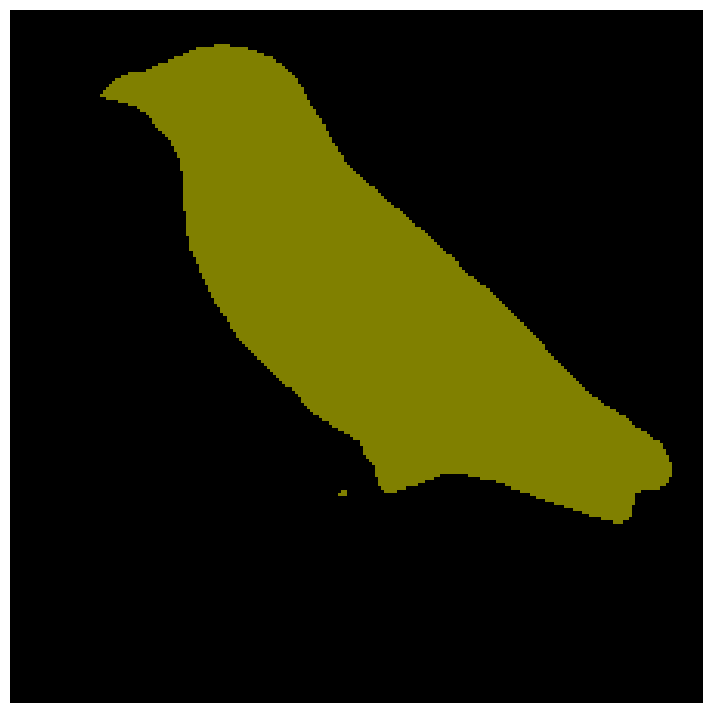

In [10]:
rgb = decode_segmap(om)
plt.figure(figsize=(12, 9))
plt.imshow(rgb)
plt.axis('off')
plt.show()

Now lets move all of this intro one function

In [11]:
def segment(net, path, show_orig=True, dev='cuda'):
    plt.figure(figsize=(10, 7))
    img = Image.open(path)
    if show_orig:
        plt.imshow(img)
        plt.axis('off')
        plt.show()
    # Comment the Resize and CenterCrop for better inference results
    trf = T.Compose([T.Resize(640),
                   #T.CenterCrop(224),
                   T.ToTensor(),
                   T.Normalize(mean = [0.485, 0.456, 0.406],
                               std = [0.229, 0.224, 0.225])])
    inp = trf(img).unsqueeze(0).to(dev)
    out = net.to(dev)(inp)['out']
    om = torch.argmax(out.squeeze(), dim=0).detach().cpu().numpy()
    rgb = decode_segmap(om)
    plt.figure(figsize=(10, 7))
    plt.imshow(rgb)
    plt.axis('off')
    plt.show()

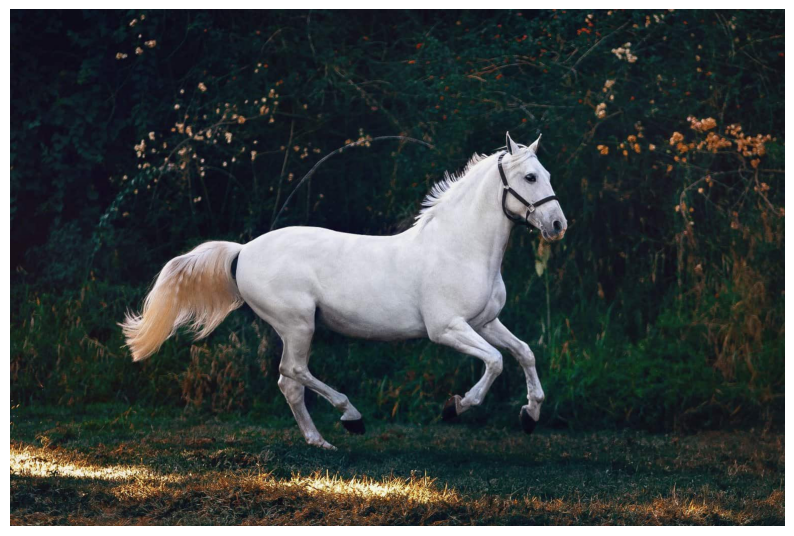

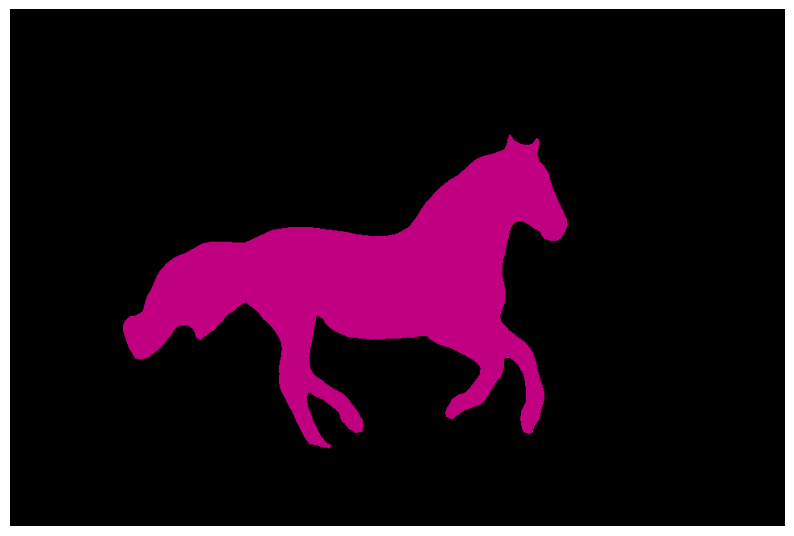

In [12]:
download_file(
    'https://www.learnopencv.com/wp-content/uploads/2021/01/horse-segmentation.jpeg',
     save_name=os.path.join(inference_dir, 'horse.jpg')
)
segment(fcn, os.path.join(inference_dir, 'horse.jpg'))

Lets use another model!

In [13]:
dlab = models.segmentation.deeplabv3_resnet101(
    weights='COCO_WITH_VOC_LABELS_V1'
#     pretrained=True
).eval()

Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to C:\Users\rdinh/.cache\torch\hub\checkpoints\deeplabv3_resnet101_coco-586e9e4e.pth
100%|██████████| 233M/233M [00:24<00:00, 10.1MB/s] 


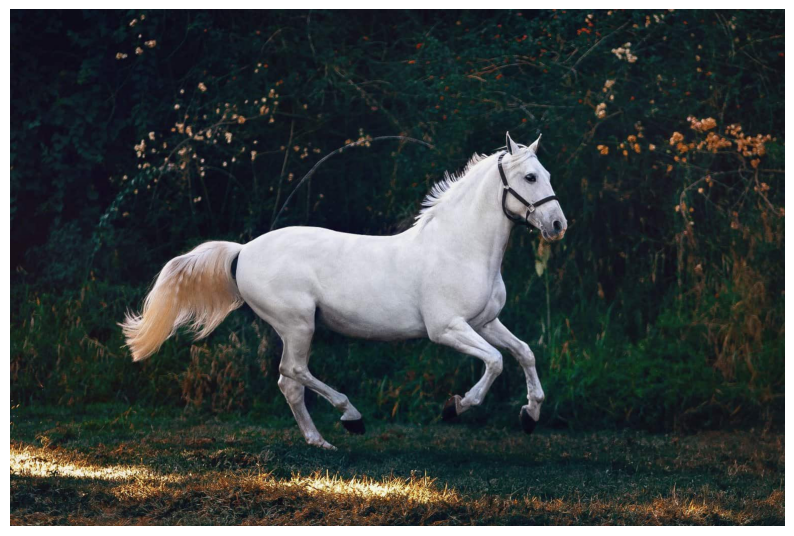

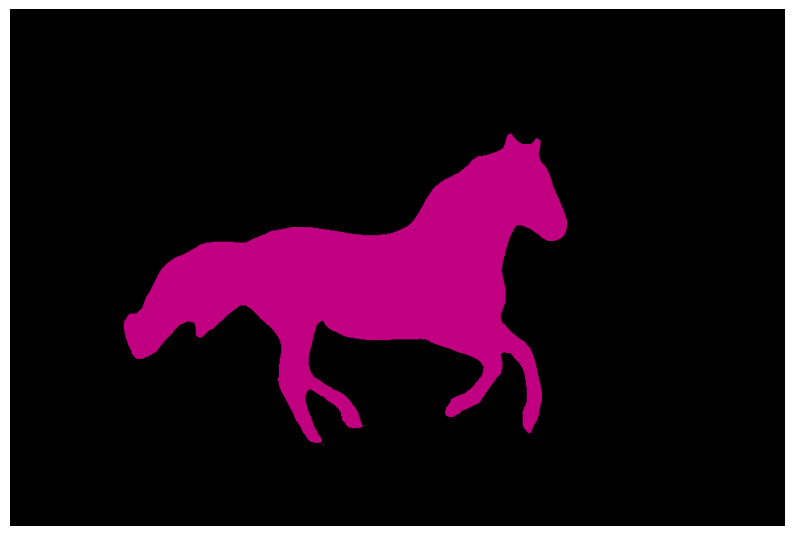

In [14]:
segment(dlab, os.path.join(inference_dir, 'horse.jpg'))

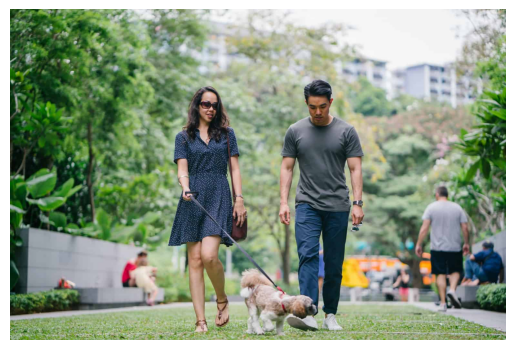

Segmenatation Image on FCN


<Figure size 1000x700 with 0 Axes>

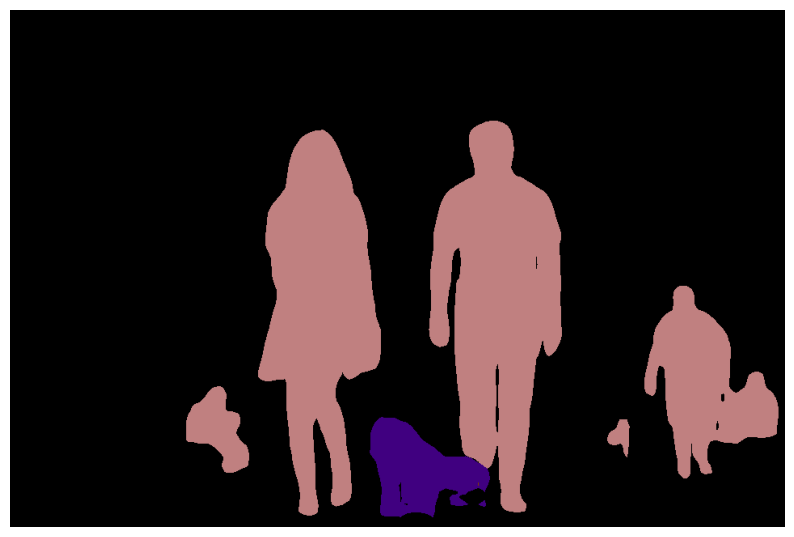

Segmenatation Image on DeepLabv3


<Figure size 1000x700 with 0 Axes>

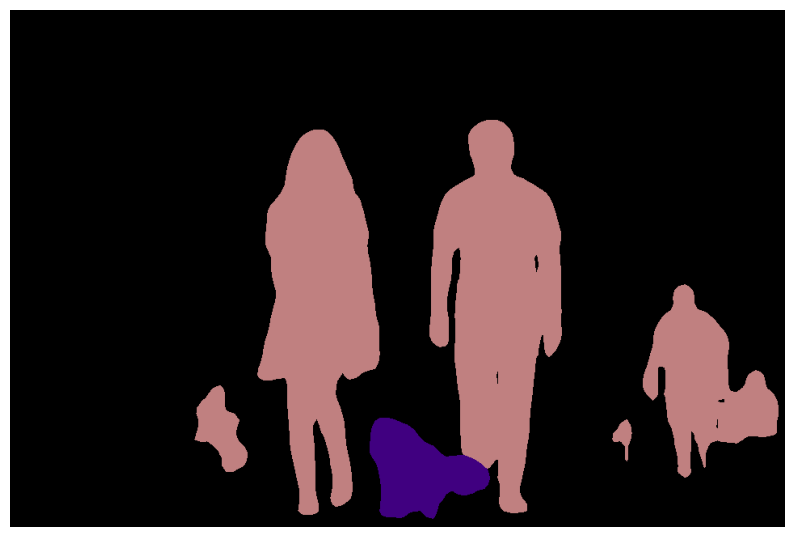

In [15]:
download_file(
    'https://www.learnopencv.com/wp-content/uploads/2021/01/person-segmentation.jpeg',
    save_name=os.path.join(inference_dir, 'person.jpg')
)
img = Image.open(os.path.join(inference_dir, 'person.jpg'))
plt.imshow(img)
plt.axis('off')
plt.show()

print ('Segmenatation Image on FCN')
segment(fcn, path=os.path.join(inference_dir, 'person.jpg'), show_orig=False)

print ('Segmenatation Image on DeepLabv3')
segment(dlab, path=os.path.join(inference_dir, 'person.jpg'), show_orig=False)

Lets compare the two models on inference time, size of model, and GPU memory used

In [16]:
def infer_time(net, path=os.path.join(inference_dir, 'horse.jpg'), dev='cuda'):
    img = Image.open(path)
    trf = T.Compose([T.Resize(256),
                   T.CenterCrop(224),
                   T.ToTensor(),
                   T.Normalize(mean = [0.485, 0.456, 0.406],
                               std = [0.229, 0.224, 0.225])])

    inp = trf(img).unsqueeze(0).to(dev)

    st = time.time()
    out1 = net.to(dev)(inp)
    et = time.time()

    return et - st

In [18]:
# On CPU
avg_over = 100

fcn_infer_time_list_cpu = [infer_time(fcn, dev='cpu') for _ in range(avg_over)]
fcn_infer_time_avg_cpu = sum(fcn_infer_time_list_cpu) / avg_over

dlab_infer_time_list_cpu = [infer_time(dlab, dev='cpu') for _ in range(avg_over)]
dlab_infer_time_avg_cpu = sum(dlab_infer_time_list_cpu) / avg_over


print ('Inference time for first few calls for FCN      : {}'.format(fcn_infer_time_list_cpu[:10]))
print ('Inference time for first few calls for DeepLabv3: {}'.format(dlab_infer_time_list_cpu[:10]))

print ('The Average Inference time on FCN is:     {:.2f}s'.format(fcn_infer_time_avg_cpu))
print ('The Average Inference time on DeepLab is: {:.2f}s'.format(dlab_infer_time_avg_cpu))

Inference time for first few calls for FCN      : [0.1835622787475586, 0.3717801570892334, 0.18435883522033691, 0.2634871006011963, 0.2849454879760742, 0.1956632137298584, 0.3233630657196045, 0.17118024826049805, 0.15663766860961914, 0.21669507026672363]
Inference time for first few calls for DeepLabv3: [0.36280107498168945, 0.18451571464538574, 0.18627047538757324, 0.1878337860107422, 0.20235729217529297, 0.19197750091552734, 0.17998886108398438, 0.18773317337036133, 0.20105481147766113, 0.1958296298980713]
The Average Inference time on FCN is:     0.20s
The Average Inference time on DeepLab is: 0.20s


In [19]:
# On GPU
avg_over = 100

fcn_infer_time_list_gpu = [infer_time(fcn) for _ in range(avg_over)]
fcn_infer_time_avg_gpu = sum(fcn_infer_time_list_gpu) / avg_over

dlab_infer_time_list_gpu = [infer_time(dlab) for _ in range(avg_over)]
dlab_infer_time_avg_gpu = sum(dlab_infer_time_list_gpu) / avg_over

print ('Inference time for first few calls for FCN      : {}'.format(fcn_infer_time_list_gpu[:10]))
print ('Inference time for first few calls for DeepLabv3: {}'.format(dlab_infer_time_list_gpu[:10]))

print ('The Average Inference time on FCN is:     {:.3f}s'.format(fcn_infer_time_avg_gpu))
print ('The Average Inference time on DeepLab is: {:.3f}s'.format(dlab_infer_time_avg_gpu))

Inference time for first few calls for FCN      : [0.4027411937713623, 0.01914501190185547, 0.025643587112426758, 0.01350712776184082, 0.010767936706542969, 0.007876396179199219, 0.014095783233642578, 0.014050722122192383, 0.010123014450073242, 0.010241508483886719]
Inference time for first few calls for DeepLabv3: [0.06396269798278809, 0.014023303985595703, 0.010057926177978516, 0.010702371597290039, 0.022455215454101562, 0.011917591094970703, 0.010075807571411133, 0.01900339126586914, 0.01028895378112793, 0.005959749221801758]
The Average Inference time on FCN is:     0.016s
The Average Inference time on DeepLab is: 0.012s


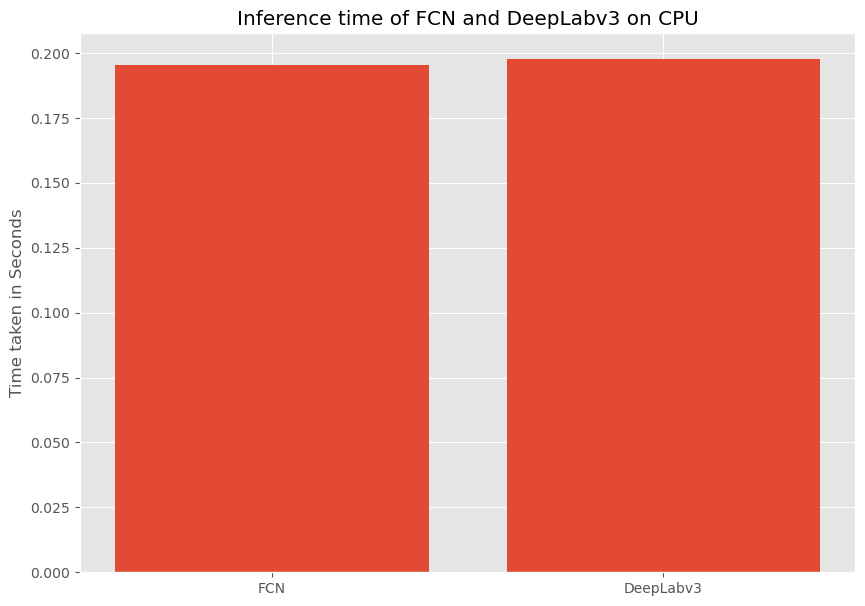

In [20]:
plt.figure(figsize=(10, 7))
plt.bar([0.1, 0.2], [fcn_infer_time_avg_cpu, dlab_infer_time_avg_cpu], width=0.08)
plt.ylabel('Time taken in Seconds')
plt.xticks([0.1, 0.2], ['FCN', 'DeepLabv3'])
plt.title('Inference time of FCN and DeepLabv3 on CPU')
plt.show()

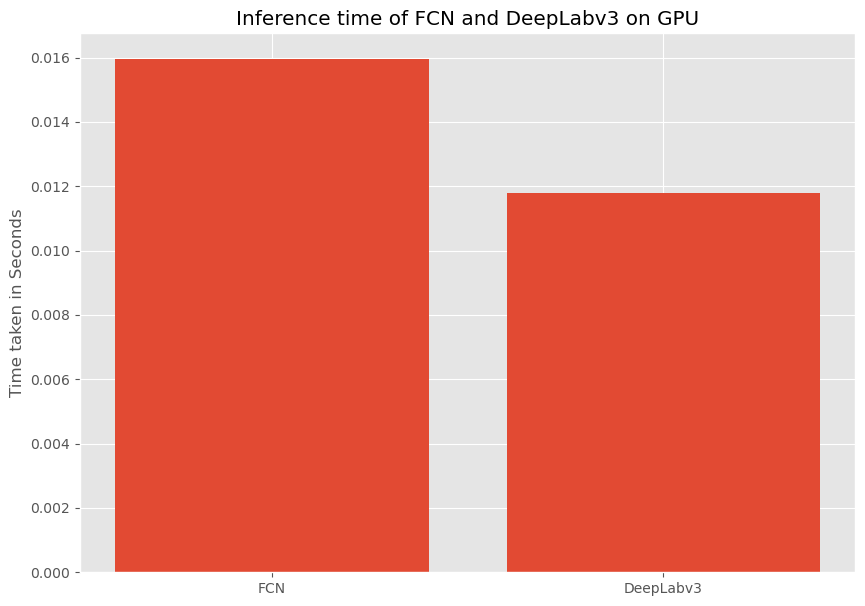

In [21]:
plt.figure(figsize=(10, 7))
plt.bar([0.1, 0.2], [fcn_infer_time_avg_gpu, dlab_infer_time_avg_gpu], width=0.08)
plt.ylabel('Time taken in Seconds')
plt.xticks([0.1, 0.2], ['FCN', 'DeepLabv3'])
plt.title('Inference time of FCN and DeepLabv3 on GPU')
plt.show()